# A generational model of gun ownership and gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [106]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('figure', figsize=(4, 3))

import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from https://gssdataexplorer.norc.org/projects/41723#

In [107]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 24)


,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,age,race,srcbelt,polviews,natcrime,gunlaw,gun,gunage,gunnum,educ
0,1972,0.0,1949,0,0.4446,0,3,18951.0,2,0,...,23,1,3,0,0,1,0,0,0,16
1,1972,0.0,1902,0,0.8893,0,4,24366.0,1,0,...,70,1,3,0,0,1,0,0,0,10
2,1972,0.0,1924,0,0.8893,0,3,24366.0,2,0,...,48,1,3,0,0,1,0,0,0,12
3,1972,0.0,1945,0,0.8893,0,3,30458.0,2,0,...,27,1,3,0,0,1,0,0,0,17
4,1972,0.0,1911,0,0.8893,0,4,50763.0,2,0,...,61,1,3,0,0,1,0,0,0,12


In [108]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [109]:
def numnull(series):
    return sum(series.isnull())

In [110]:
replace_invalid(gss)

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [111]:
numnull(gss.gunlaw)

21994

In [112]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [113]:
numnull(gss.owngun)

24826

In [114]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [115]:
numnull(gss.gun)

43138

In [116]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [117]:
numnull(gss.natcrime)

28064

In [118]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [119]:
varname = 'income'
numnull(gss[varname])

7961

In [120]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [121]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [122]:
varname = 'realinc'
numnull(gss[varname])

6325

In [123]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [124]:
varname = 'educ'
numnull(gss[varname])

174

In [125]:
utils.values(gss, varname)

0.0       161
1.0        45
2.0       148
3.0       247
4.0       314
5.0       399
6.0       808
7.0       871
8.0      2689
9.0      2032
10.0     2815
11.0     3648
12.0    19006
13.0     5177
14.0     6847
15.0     2783
16.0     7925
17.0     1870
18.0     2265
19.0      875
20.0     1367
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [126]:
varname = 'polviews'
numnull(gss[varname])

9385

In [127]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [128]:
numnull(gss.age)

221

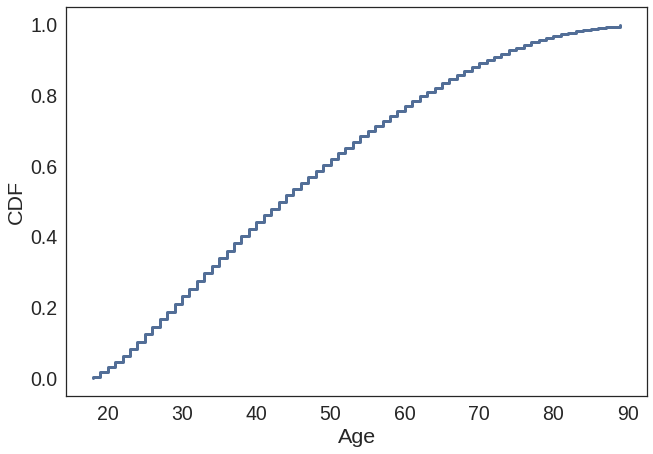

In [129]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [130]:
numnull(gss.cohort)

221

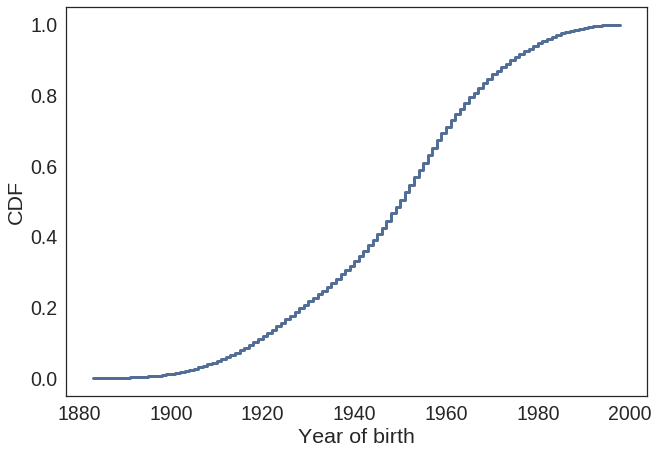

In [131]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [132]:
numnull(gss.sex)

0

In [133]:
utils.values(gss, 'sex')

1    27562
2    34904
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [134]:
numnull(gss.race)

0

In [135]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

### Hispanic 



In [136]:
numnull(gss.hispanic)

38149

In [137]:
utils.values(gss, 'hispanic')

1.0     21571
2.0      1661
3.0       346
4.0       115
5.0        91
6.0        52
7.0        14
8.0        18
9.0         3
10.0       25
11.0       38
15.0       63
16.0        1
20.0       27
21.0       32
22.0       37
23.0       13
24.0       12
25.0        3
30.0      121
31.0        2
35.0        7
40.0        5
41.0       21
42.0        1
45.0        3
46.0       12
47.0       13
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [138]:
numnull(gss.srcbelt)

0

In [139]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

### Make age and cohort groups

Group people into 5- and 10-year bins by birth year.

In [140]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5

In [141]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()           # count cases where we have the dependent var
counts

cohort5
1884.5      15
1889.5      85
1894.5     216
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     213
1999.5      14
2004.5     132
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [142]:
gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5

In [143]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     227
2004.5     132
Name: gunlaw, dtype: int64

In [144]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [145]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     393
2000.0     132
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [146]:
utils.values(gss, 'year')

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

Group into 4 year intervals, chosen to get 2014 and 2016 into the last bin.

In [147]:
gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
utils.values(gss, 'year4')

1971    3117
1975    6003
1979    3000
1983    6466
1987    6307
1991    4495
1995    5896
1999    5649
2003    5577
2007    6533
2011    4018
2015    5405
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [148]:
gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
utils.values(gss, 'age5')

17.5    1054
22.5    5283
27.5    6663
32.5    6784
37.5    6475
42.5    5924
47.5    5375
52.5    5007
57.5    4530
62.5    4047
67.5    3612
72.5    2955
77.5    2207
82.5    1381
87.5     948
92.5     221
Name: age5, dtype: int64

In [149]:
gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
utils.values(gss, 'age3')

19.5    1924
22.5    3238
25.5    3815
28.5    4023
31.5    4094
34.5    4033
37.5    3951
40.5    3609
43.5    3496
46.5    3217
49.5    3178
52.5    3019
55.5    2817
58.5    2681
61.5    2538
64.5    2289
67.5    2184
70.5    1913
73.5    1690
76.5    1418
79.5    1114
82.5     840
85.5     573
88.5     591
91.5     221
Name: age3, dtype: int64

### Make booleans

In [150]:
def copy_nan(df, varname, newvar):
    df.loc[df[varname].isnull(), newvar] = np.nan

In [151]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [152]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    per25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= per25 
    copy_nan(df, 'realinc', 'lowrealinc')

    per75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= per75 
    copy_nan(df, 'realinc', 'highrealinc')

make_booleans(gss)

### Resample

In [153]:
sample = utils.ResampleByYear(gss).copy()
sample.shape

(62466, 56)

In [154]:
utils.values(sample, 'twenties')

0.0    56599
1.0     5867
Name: twenties, dtype: int64

In [155]:
utils.values(sample, 'thirties')

0.0    55629
1.0     6837
Name: thirties, dtype: int64

In [156]:
utils.values(sample, 'forties')

0.0    52342
1.0    10124
Name: forties, dtype: int64

In [157]:
utils.values(sample, 'fifties')

0.0    49406
1.0    13060
Name: fifties, dtype: int64

In [158]:
utils.values(sample, 'sixties')

0.0    52616
1.0     9850
Name: sixties, dtype: int64

In [159]:
utils.values(sample, 'seventies')

0.0    56215
1.0     6251
Name: seventies, dtype: int64

In [160]:
utils.values(sample, 'eighties')

0.0    58967
1.0     3499
Name: eighties, dtype: int64

In [161]:
utils.values(sample, 'nineties')

0.0    61550
1.0      916
Name: nineties, dtype: int64

In [162]:
utils.values(sample, 'favor')

0.0     9618
1.0    30707
Name: favor, dtype: int64

In [163]:
utils.values(sample, 'gunhome')

0.0    21504
1.0    15941
Name: gunhome, dtype: int64

In [164]:
utils.values(sample, 'threatened')

0.0    15458
1.0     3832
Name: threatened, dtype: int64

In [165]:
utils.values(sample, 'spendcrime')

0.0    11238
1.0    23259
Name: spendcrime, dtype: int64

In [166]:
utils.values(sample, 'topincome')

0.0    24170
1.0    29892
Name: topincome, dtype: int64

In [167]:
utils.values(sample, 'lowincome')

0.0    45539
1.0     8523
Name: lowincome, dtype: int64

In [168]:
utils.values(sample, 'lowrealinc')

0.0    44033
1.0    11688
Name: lowrealinc, dtype: int64

In [169]:
utils.values(sample, 'highrealinc')

0.0    39256
1.0    16465
Name: highrealinc, dtype: int64

In [170]:
utils.values(sample, 'liberal')

0.0    38888
1.0    14346
Name: liberal, dtype: int64

In [171]:
utils.values(sample, 'moderate')

0.0    32711
1.0    20523
Name: moderate, dtype: int64

In [172]:
utils.values(sample, 'conservative')

0.0    43521
1.0     9713
Name: conservative, dtype: int64

In [173]:
utils.values(sample, 'female')

0.0    28558
1.0    33908
Name: female, dtype: int64

In [174]:
utils.values(sample, 'ishisp')

0.0    22471
1.0     1845
Name: ishisp, dtype: int64

In [175]:
utils.values(sample, 'black')

0.0    53955
1.0     8511
Name: black, dtype: int64

In [176]:
utils.values(sample, 'otherrace')

0.0    58747
1.0     3719
Name: otherrace, dtype: int64

In [177]:
utils.values(sample, 'urban')

0.0    25287
1.0    37179
Name: urban, dtype: int64

In [178]:
utils.values(sample, 'suburban')

0.0    45282
1.0    17184
Name: suburban, dtype: int64

In [179]:
utils.values(sample, 'rural')

0.0    54363
1.0     8103
Name: rural, dtype: int64

In [180]:
utils.values(sample, 'college')

0.0    33151
1.0    29156
Name: college, dtype: int64

### Look at trends

In [181]:
def plot_series(grouped, varname, **options):
    series = grouped[varname].mean() * 100
    thinkplot.plot(series.dropna(), **options, label=varname)
    thinkplot.config(xlabel='Year of survey', 
                     ylabel='Percent',
                     xlim=[1971, 2017])

In [182]:
grouped_year4 = sample.groupby('year4')

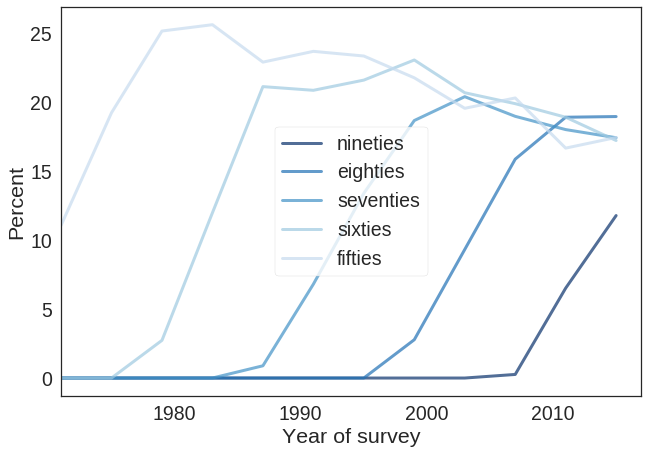

In [183]:
plot_series(grouped_year4, 'nineties')
plot_series(grouped_year4, 'eighties')
plot_series(grouped_year4, 'seventies')
plot_series(grouped_year4, 'sixties')
plot_series(grouped_year4, 'fifties')

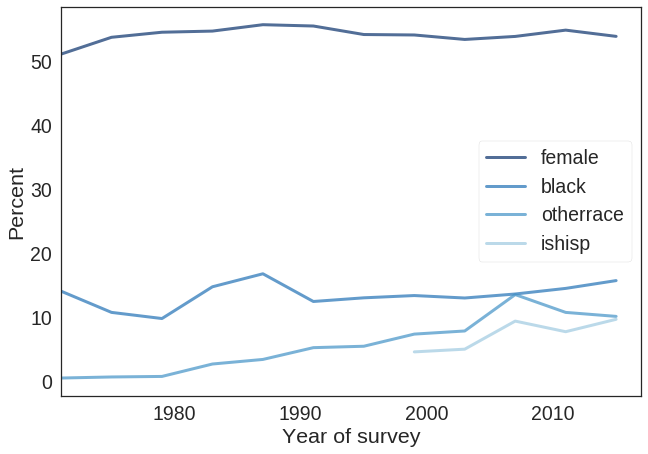

In [184]:
plot_series(grouped_year4, 'female')
plot_series(grouped_year4, 'black')
plot_series(grouped_year4, 'otherrace')
plot_series(grouped_year4, 'ishisp')

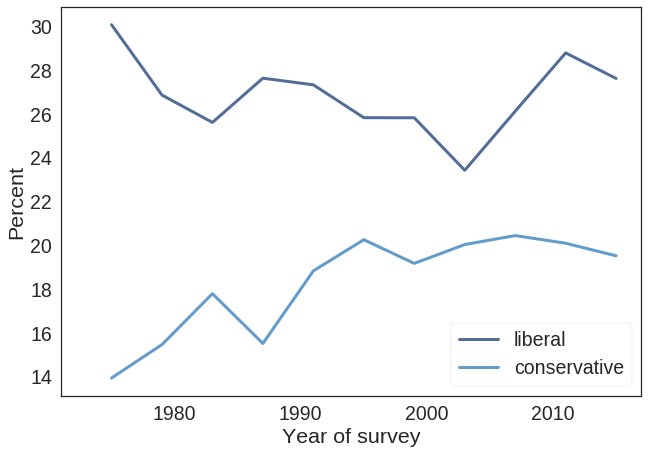

In [185]:
plot_series(grouped_year4, 'liberal')
plot_series(grouped_year4, 'conservative')

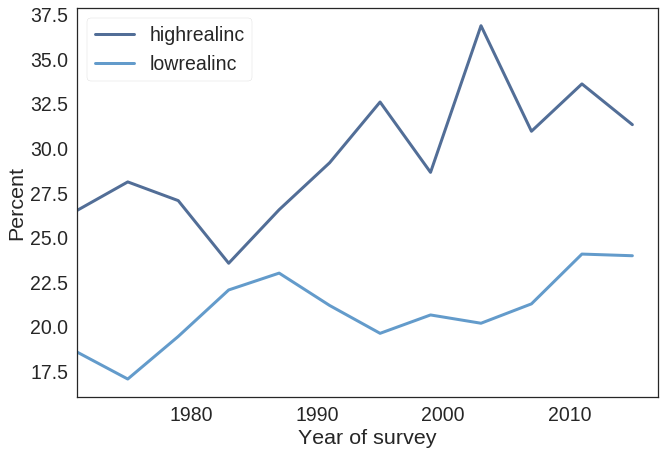

In [186]:
plot_series(grouped_year4, 'highrealinc')
plot_series(grouped_year4, 'lowrealinc')

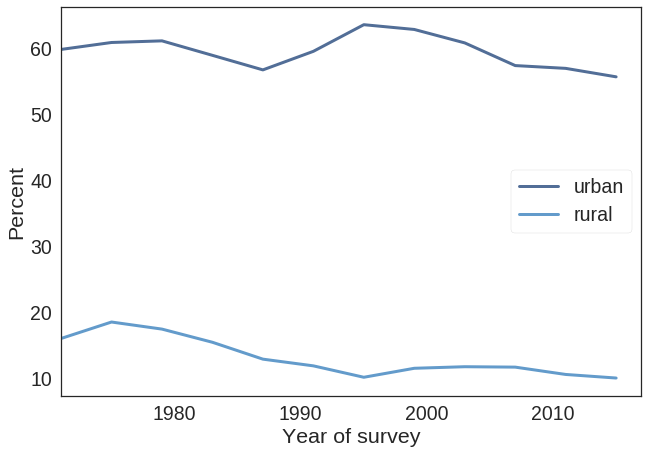

In [187]:
plot_series(grouped_year4, 'urban')
plot_series(grouped_year4, 'rural')

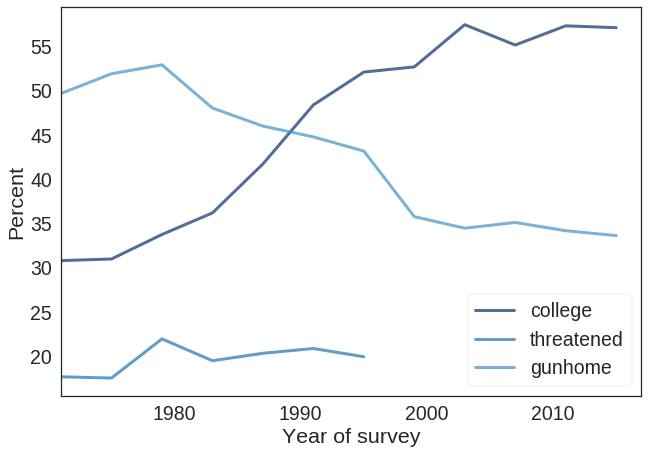

In [188]:
plot_series(grouped_year4, 'college')
plot_series(grouped_year4, 'threatened')
plot_series(grouped_year4, 'gunhome')

### Fill missing values

In [189]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [190]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [191]:
def fill_all_missing(df):
    varnames = ['year', 'cohort', 'owngun', 'gun', 'natcrime', 'income', 'realinc', 'educ',
                'polviews', 'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
    fill_age(df)

In [192]:
fill_all_missing(sample)

year 0
cohort 200
owngun 25021
gun 43176
natcrime 27969
income 8404
realinc 6745
educ 159
polviews 9232
sex 0
race 0
hispanic 38150
srcbelt 0
age 201


After filling, we have to make booleans again.

In [193]:
make_booleans(sample)

### Center cohort, age, and year.

In [194]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['ac'] = df.a * df.c

In [195]:
center_factors(sample)

### Run logistic models



Drop records if we don't have the dependent variable.

In [196]:
subset = sample.dropna(subset=['gunlaw'])
subset.shape

(40325, 64)

How many records did we lose?

In [197]:
sample.shape[0] - subset.shape[0]

22141

In [198]:
subset.head()

,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,lowrealinc,highrealinc,ones,c,a,y,c2,a2,y2,ac
0,1972,0.0,1919.0,0,1.3339,12.0,3,24366.0,1,0,...,0.0,0.0,1.0,-47.0,6.0,-18,2209.0,36.0,324,-282.0
1,1972,0.0,1940.0,0,1.3339,12.0,4,60915.0,1,0,...,0.0,1.0,1.0,-26.0,-15.0,-18,676.0,225.0,324,390.0
2,1972,0.0,1942.0,0,0.8893,12.0,4,43994.0,1,0,...,0.0,1.0,1.0,-24.0,-17.0,-18,576.0,289.0,324,408.0
3,1972,0.0,1934.0,0,0.8893,10.0,2,30458.0,2,0,...,0.0,0.0,1.0,-32.0,-9.0,-18,1024.0,81.0,324,288.0
4,1972,0.0,1914.0,0,0.8893,12.0,3,18951.0,2,0,...,0.0,0.0,1.0,-52.0,11.0,-18,2704.0,121.0,324,-572.0


In [199]:
sample.columns

Index(['year', 'conrinc', 'cohort', 'ballot', 'wtssall', 'income', 'finrela',
       'realinc', 'sex', 'homosex', 'hispanic', 'rowngun', 'owngun', 'id_',
       'age', 'race', 'srcbelt', 'polviews', 'natcrime', 'gunlaw', 'gun',
       'gunage', 'gunnum', 'educ', 'cohort5', 'cohort10', 'year4', 'age5',
       'age3', 'twenties', 'thirties', 'forties', 'fifties', 'sixties',
       'seventies', 'eighties', 'nineties', 'favor', 'gunhome', 'threatened',
       'spendcrime', 'topincome', 'lowincome', 'liberal', 'moderate',
       'conservative', 'female', 'ishisp', 'black', 'otherrace', 'urban',
       'suburban', 'rural', 'college', 'lowrealinc', 'highrealinc', 'ones',
       'c', 'a', 'y', 'c2', 'a2', 'y2', 'ac'],
      dtype='object')

In [200]:
varnames = ['nineties', 'eighties', 'seventies', 'fifties', 'forties', 'thirties', 'twenties',
            'female', 'black', 'otherrace', 'ishisp', 'conservative', 'liberal', 'lowrealinc', 'highrealinc',
            'college', 'urban', 'rural', 'threatened', 'gunhome']

all_varnames = varnames + ['y', 'y2', 'favor']

In [201]:
for varname in varnames:
    print(varname, sum(sample[varname].isnull()))

nineties 0
eighties 0
seventies 0
fifties 0
forties 0
thirties 0
twenties 0
female 0
black 0
otherrace 0
ishisp 0
conservative 0
liberal 0
lowrealinc 0
highrealinc 0
college 0
urban 0
rural 0
threatened 0
gunhome 0


Select just the columns we need

In [202]:
data = subset[all_varnames]
data.shape

(40325, 23)

In [264]:
formula = ('favor ~ y + y2 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
model = smf.logit(formula, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.503954
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40325
Model:                          Logit   Df Residuals:                    40302
Method:                           MLE   Df Model:                           22
Date:                Thu, 15 Mar 2018   Pseudo R-squ.:                 0.08265
Time:                        15:07:13   Log-Likelihood:                -20322.
converged:                       True   LL-Null:                       -22153.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.7243      0.046     37.242      0.000       1.634       1.815
y                0.0070      0.001      6.225      0.000       0.005       0.009
y2              -0.0009   7.61e-05    -11.910      0.000      -0.001      -0.001
nineties        -0.6031      0.106     -5.691      0.000      -0.811      -0.395
eighties        -0.3888      0.065     -6.006      0.000      -0.516      -0.262
seventies       -0.2178      0.051     -4.255      0.000      -0.318      -0.117
fifties         -0.0958      0.037     -2.579      0.010      -0.169      -0.023
forties         -0.0083      0.039     -0.209      0.834      -0.086       0.069
thirties        -0.1520      0.043     -3.532      0.000      -0.236      -0.068
twenties        -0.0238      0.045     -0.526      0.599      -0.113       0.065
female           0.6948      0.025     27.842      0.000       0.646       0.744
black            0.2991      0.040      7.559      0.000       0.222       0.377
otherrace        0.3905      0.065      6.024      0.000       0.263       0.518
ishisp          -0.0302      0.047     -0.642      0.521      -0.122       0.062
conservative    -0.3754      0.031    -12.004      0.000      -0.437      -0.314
liberal          0.2627      0.031      8.552      0.000       0.203       0.323
lowrealinc      -0.1527      0.031     -4.900      0.000      -0.214      -0.092
highrealinc      0.0584      0.031      1.891      0.059      -0.002       0.119
college          0.1248      0.027      4.669      0.000       0.072       0.177
urban           -0.2870      0.031     -9.326      0.000      -0.347      -0.227
rural           -0.5677      0.041    -13.741      0.000      -0.649      -0.487
threatened      -0.1604      0.030     -5.316      0.000      -0.220      -0.101
gunhome         -0.8890      0.026    -34.192      0.000      -0.940      -0.838
================================================================================
"""

Make a row for someone in 2016 with all booleans false.

In [265]:
def make_base():
    y = 2016 - 1990
    y2 = y**2

    d = dict(y=y, y2=y2)
    for varname in varnames:
        d[varname] = 0

    return pd.Series(d)

base = make_row()
base

black             0
college           0
conservative      0
eighties          0
female            0
fifties           0
forties           0
gunhome           0
highrealinc       0
ishisp            0
liberal           0
lowrealinc        0
nineties          0
otherrace         0
rural             0
seventies         0
thirties          0
threatened        0
twenties          0
urban             0
y                26
y2              676
dtype: int64

Make a DataFrame that contains one row for each case we want to consider.

In [266]:
def add_yminus(df, varname, offset):
    """
    
    """
    df.loc[varname] = s
    df.loc[varname, 'y'] += offset
    df.loc[varname, 'y2'] = df.loc[varname, 'y']**2

In [318]:
def make_df_pred():
    base = make_base()
    df_pred = pd.DataFrame(columns=base.index, dtype=float)
    #df_pred = pd.DataFrame(columns=sample.columns)
    
    df_pred.loc['base'] = s

    for varname in varnames:
        df_pred.loc[varname] = s
        df_pred.loc[varname, varname] = 1
    
    add_yminus(df_pred, 'yminus10', -10)
    add_yminus(df_pred, 'yminus20', -20)
    add_yminus(df_pred, 'yminus30', -30)
    add_yminus(df_pred, 'yminus40', -40)
    
    df_pred.loc['lowest combo'] = s
    low_vars = ['gunhome', 'nineties', 'rural', 
                'conservative', 'lowrealinc', 'threatened']
    df_pred.loc['lowest combo', low_vars] = 1
    
    df_pred.loc['highest combo'] = s
    high_vars = ['female', 'otherrace', 'liberal', 
                'college', 'highrealinc']
    df_pred.loc['highest combo', high_vars] = 1
    
    return df_pred
    
df_pred = make_df_pred()
df_pred

,black,college,conservative,eighties,female,fifties,forties,gunhome,highrealinc,ishisp,...,nineties,otherrace,rural,seventies,thirties,threatened,twenties,urban,y,y2
base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0
nineties,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0
eighties,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0
seventies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.0,676.0
fifties,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0
forties,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0
thirties,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,676.0
twenties,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.0,676.0
female,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0
black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0


In [319]:
pred = model.predict(df_pred) * 100
pred

base             78.485429
nineties         66.621696
eighties         71.205662
seventies        74.580045
fifties          76.822925
forties          78.345758
thirties         75.807540
twenties         78.080717
female           87.964039
black            83.108290
otherrace        84.353016
ishisp           77.971727
conservative     71.479353
liberal          82.591260
lowrealinc       75.795184
highrealinc      79.455948
college          80.517546
urban            73.247706
rural            67.403498
threatened       75.653796
gunhome          59.992119
yminus10         83.266429
yminus20         84.989607
yminus30         84.312362
yminus40         80.972689
lowest combo     18.937065
highest combo    94.404125
dtype: float64

In [320]:
pred - pred['base']

base              0.000000
nineties        -11.863732
eighties         -7.279767
seventies        -3.905383
fifties          -1.662504
forties          -0.139670
thirties         -2.677888
twenties         -0.404711
female            9.478610
black             4.622861
otherrace         5.867587
ishisp           -0.513701
conservative     -7.006076
liberal           4.105831
lowrealinc       -2.690245
highrealinc       0.970520
college           2.032117
urban            -5.237723
rural           -11.081931
threatened       -2.831633
gunhome         -18.493310
yminus10          4.781000
yminus20          6.504178
yminus30          5.826934
yminus40          2.487260
lowest combo    -59.548364
highest combo    15.918696
dtype: float64

In [321]:
def make_result(pred):
    result = pd.DataFrame()
    result['pred'] = pred
    result['offset'] = pred - pred['base']
    return result

result = make_result(pred)
result

,pred,offset
base,78.485429,0.000000
nineties,66.621696,-11.863732
eighties,71.205662,-7.279767
seventies,74.580045,-3.905383
fifties,76.822925,-1.662504
forties,78.345758,-0.139670
thirties,75.807540,-2.677888
twenties,78.080717,-0.404711
female,87.964039,9.478610
black,83.108290,4.622861


### Iterate

In [322]:
def run(iters=101):
    gss = utils.ReadGss('gss_gun')
    replace_invalid(gss)
    formula = ('favor ~ y + y2 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + '
           'college + urban + rural + threatened + gunhome')
    
    results = []
    for i in range(iters):
        sample = utils.ResampleByYear(gss).copy()
        fill_all_missing(sample)
        make_booleans(sample)
        center_factors(sample)
        data = sample.dropna(subset=['gunlaw'])
    
        model = smf.logit(formula, data=data).fit()

        df_pred = make_df_pred()
        pred = model.predict(df_pred) * 100
        result = make_result(pred)
        
        results.append(result)
    return results

In [323]:
results = run()

year 0
cohort 186
owngun 24761
gun 43165
natcrime 28093
income 8539
realinc 6898
educ 164
polviews 9302
sex 0
race 0
hispanic 38154
srcbelt 0
age 184
Optimization terminated successfully.
         Current function value: 0.501896
         Iterations 6
year 0
cohort 193
owngun 24793
gun 43194
natcrime 28013
income 8499
realinc 6877
educ 184
polviews 9322
sex 0
race 0
hispanic 38154
srcbelt 0
age 193
Optimization terminated successfully.
         Current function value: 0.499718
         Iterations 6
year 0
cohort 165
owngun 24880
gun 43154
natcrime 27921
income 8589
realinc 6940
educ 175
polviews 9305
sex 0
race 0
hispanic 38147
srcbelt 0
age 166
Optimization terminated successfully.
         Current function value: 0.505204
         Iterations 6
year 0
cohort 176
owngun 24796
gun 43186
natcrime 27858
income 8391
realinc 6773
educ 135
polviews 9322
sex 0
race 0
hispanic 38147
srcbelt 0
age 176
Optimization terminated successfully.
         Current function value: 0.508381
         Itera

Optimization terminated successfully.
         Current function value: 0.503740
         Iterations 6
year 0
cohort 181
owngun 24949
gun 43139
natcrime 28234
income 8561
realinc 6935
educ 173
polviews 9444
sex 0
race 0
hispanic 38150
srcbelt 0
age 183
Optimization terminated successfully.
         Current function value: 0.500117
         Iterations 6
year 0
cohort 189
owngun 24892
gun 43158
natcrime 27731
income 8594
realinc 6913
educ 155
polviews 9351
sex 0
race 0
hispanic 38159
srcbelt 0
age 189
Optimization terminated successfully.
         Current function value: 0.507933
         Iterations 6
year 0
cohort 186
owngun 24776
gun 43144
natcrime 27910
income 8454
realinc 6817
educ 169
polviews 9292
sex 0
race 0
hispanic 38153
srcbelt 0
age 185
Optimization terminated successfully.
         Current function value: 0.503465
         Iterations 6
year 0
cohort 172
owngun 24753
gun 43171
natcrime 27907
income 8585
realinc 6961
educ 173
polviews 9278
sex 0
race 0
hispanic 38157
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.504043
         Iterations 6
year 0
cohort 196
owngun 24806
gun 43112
natcrime 27989
income 8466
realinc 6810
educ 156
polviews 9456
sex 0
race 0
hispanic 38156
srcbelt 0
age 197
Optimization terminated successfully.
         Current function value: 0.504063
         Iterations 6
year 0
cohort 180
owngun 24933
gun 43218
natcrime 28102
income 8525
realinc 6890
educ 151
polviews 9294
sex 0
race 0
hispanic 38151
srcbelt 0
age 180
Optimization terminated successfully.
         Current function value: 0.504146
         Iterations 6
year 0
cohort 191
owngun 24776
gun 43114
natcrime 27905
income 8417
realinc 6750
educ 152
polviews 9299
sex 0
race 0
hispanic 38151
srcbelt 0
age 191
Optimization terminated successfully.
         Current function value: 0.502415
         Iterations 6
year 0
cohort 185
owngun 24796
gun 43207
natcrime 28069
income 8417
realinc 6756
educ 177
polviews 9277
sex 0
race 0
hispanic 38145
srcbelt 0


Optimization terminated successfully.
         Current function value: 0.501846
         Iterations 6
year 0
cohort 213
owngun 24851
gun 43077
natcrime 28009
income 8355
realinc 6730
educ 165
polviews 9306
sex 0
race 0
hispanic 38154
srcbelt 0
age 214
Optimization terminated successfully.
         Current function value: 0.506711
         Iterations 6
year 0
cohort 178
owngun 24882
gun 43188
natcrime 27920
income 8400
realinc 6777
educ 173
polviews 9427
sex 0
race 0
hispanic 38143
srcbelt 0
age 178
Optimization terminated successfully.
         Current function value: 0.505608
         Iterations 6


In [324]:
preds = [result.pred for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 5, 95])

estimates = pd.DataFrame(index=result.index)
estimates['low2.5'] = low
estimates['median'] = median
estimates['high97.5'] = high
estimates.round(1)

,low2.5,median,high97.5
base,76.3,78.0,79.2
nineties,63.3,66.2,70.0
eighties,70.9,72.9,75.1
seventies,74.3,75.9,77.9
fifties,75.9,77.3,78.7
forties,76.3,78.0,79.4
thirties,75.0,76.5,78.3
twenties,75.5,77.3,78.7
female,86.3,87.4,88.4
black,79.9,81.7,83.2


In [328]:
lines = estimates.round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>base</th>
      <td>76.3</td>
      <td>78.0</td>
      <td>79.2</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>63.3</td>
      <td>66.2</td>
      <td>70.0</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>70.9</td>
      <td>72.9</td>
      <td>75.1</td>
    </tr>
    <tr>
      <th>seventies</th>
      <td>74.3</td>
      <td>75.9</td>
      <td>77.9</td>
    </tr>
    <tr>
      <th>fifties</th>
      <td>75.9</td>
      <td>77.3</td>
      <td>78.7</td>
    </tr>
    <tr>
      <th>forties</th>
      <td>76.3</td>
      <td>78.0</td>
      <td>79.4</td>
    </tr>
    <tr>
      <th>thirties</th>
      <td>75.0</td>
      <td>76.5</td>
      <td>78.3</td>
    </tr>
    <tr>
      <th>twenties</th>
      <td>75.5</td>
      <td>77.3</td>
      <td>78.

In [326]:
preds = [result.offset for result in results]
median, low, high = thinkstats2.PercentileRows(preds, [50, 2.5, 97.5])

offsets = pd.DataFrame(index=result.index)
offsets['low2.5'] = low
offsets['median'] = median
offsets['high97.5'] = high
offsets.sort_values('median').round(1)

,low2.5,median,high97.5
lowest combo,-61.1,-57.0,-52.0
gunhome,-20.1,-18.7,-17.6
nineties,-15.3,-11.7,-7.2
rural,-12.1,-10.4,-8.7
conservative,-8.1,-6.7,-5.7
eighties,-7.5,-4.9,-2.4
urban,-5.6,-4.6,-3.5
lowrealinc,-3.3,-2.2,-1.1
seventies,-3.6,-2.0,0.0
threatened,-2.8,-2.0,-1.0


In [329]:
lines = offsets.sort_values('median').round(1).to_html().split('\n')
for line in lines:
    print(line)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>low2.5</th>
      <th>median</th>
      <th>high97.5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>lowest combo</th>
      <td>-61.1</td>
      <td>-57.0</td>
      <td>-52.0</td>
    </tr>
    <tr>
      <th>gunhome</th>
      <td>-20.1</td>
      <td>-18.7</td>
      <td>-17.6</td>
    </tr>
    <tr>
      <th>nineties</th>
      <td>-15.3</td>
      <td>-11.7</td>
      <td>-7.2</td>
    </tr>
    <tr>
      <th>rural</th>
      <td>-12.1</td>
      <td>-10.4</td>
      <td>-8.7</td>
    </tr>
    <tr>
      <th>conservative</th>
      <td>-8.1</td>
      <td>-6.7</td>
      <td>-5.7</td>
    </tr>
    <tr>
      <th>eighties</th>
      <td>-7.5</td>
      <td>-4.9</td>
      <td>-2.4</td>
    </tr>
    <tr>
      <th>urban</th>
      <td>-5.6</td>
      <td>-4.6</td>
      <td>-3.5</td>
    </tr>
    <tr>
      <th>lowrealinc</th>
      <td>-3.3</td>
      <td>-2.2<

### Retrodict trends

In [232]:
def predict_favor(df, model):
    """Predict the percentage of people who would favor struct gun laws.
    
    df: DataFrame
    model: model
    
    return: percentage
    """
    probs = model.predict(df)
    bools = np.random.random(len(probs)) < probs
    assert numnull(bools) == 0
    return bools.dropna().mean() * 100

In [233]:
subset.favor.mean(), predict_favor(data, model)

(0.7614879107253565, 75.858648481091137)

In [234]:
sample.favor.mean(), predict_favor(sample, model)

(0.7614879107253565, 76.710530528607563)

In [235]:
grouped_year4 = sample.groupby('year')

In [236]:
for name, group in grouped_year4:
    retro = predict_favor(group, model)
    actual = group.favor.mean() * 100
    print(name, len(group), actual, retro)

1972 1613 74.43946188340807 69.9318040918
1973 1504 74.45799457994579 71.4760638298
1974 1484 74.29938482570063 73.7870619946
1975 1490 75.68870523415978 73.6241610738
1976 1499 71.69939065673663 71.1807871915
1977 1530 72.8 71.8300653595
1978 1532 nan 76.044386423
1980 1468 70.0895933838732 74.0463215259
1982 1860 74.2998352553542 76.2365591398
1983 1599 nan 76.3602251407
1984 1473 71.25 76.0353021045
1985 1534 71.67438782263402 76.5319426336
1986 1470 nan 77.5510204082
1987 1819 72.6457399103139 80.2089059923
1988 1481 74.70651013874067 78.7981093856
1989 1537 80.03857280617164 77.2934287573
1990 1372 81.22827346465817 80.029154519
1991 1517 81.10552763819095 78.9716545814
1993 1606 80.97928436911488 79.0161892902
1994 2992 80.4989816700611 80.9826203209
1996 2904 82.60179799048123 78.9256198347
1998 2832 81.70731707317073 80.0141242938
2000 2817 81.47531891292292 79.6947106851
2002 2765 80.80697928026173 79.1681735986
2004 2812 82.33890214797135 77.880512091
2006 4510 81.40517696777

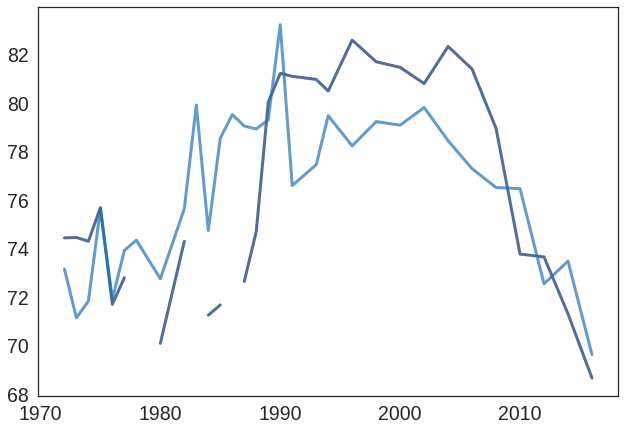

In [237]:
actual = pd.Series([])
retro = pd.Series([])
for name, group in grouped_year4:
    retro[name] = predict_favor(group, model)
    actual[name] = group.favor.mean() * 100

thinkplot.plot(actual.index, actual)
thinkplot.plot(retro.index, retro)

### Test counterfactual code

In [238]:
# may not need this any more, since sample is a copy
counterfact = sample.copy()

In [239]:
def flip(df, varname, val, new_val, prob):
    """Changes the value of a variable for a random sample of rows.
    
    Selects each row where varname==val with probability prob, and
    replaces val with new_val.
    
    df: DataFrame
    varname: string
    val: old value
    new_val: new value
    prob: probability of flipping
    """
    assert(0 < prob < 1)
    #print('flip', val, new_val, prob)
    
    # get indices of the rows that match val
    indices = np.flatnonzero(df[varname] == val)
    #print(len(indices) * prob)
    
    # flip a coin for each selected row
    cond = np.random.random(len(indices)) < prob

    # get indices of the rows that will flip
    flippers = indices[cond]
    #print(len(flippers))
    #print((df.loc[flippers, varname] == val).mean())
    
    # assign the new val to the selected rows
    labels = df.index[flippers]
    df.loc[labels, varname] = new_val

In [240]:
counterfact.college.value_counts()

0.0    33234
1.0    29232
Name: college, dtype: int64

In [241]:
flip(counterfact, 'college', 1, 0, 0.1)

In [242]:
counterfact.college.value_counts()

0.0    36069
1.0    26397
Name: college, dtype: int64

In [243]:
def adjust_prob(df, varname, desired):
    """Flip enough people to make the mean of varname equal desired.

    varname must be a 0,1 boolean

    Can only reliably make small changes.

    df: DataFrame
    varname: string column name
    desired: value between 0 and 1
    """
    actual = df[varname].mean()
    diff = desired - actual
    #print(actual, diff)
    if diff > 0:
        prob = diff / (1-actual)
        flip(df, varname, 0, 1, prob)
    elif diff < 0:
        prob = -diff / actual
        flip(df, varname, 1, 0, prob)

In [244]:
counterfact.college.value_counts()

0.0    36069
1.0    26397
Name: college, dtype: int64

In [245]:
adjust_prob(counterfact, 'college', 0.9)

In [246]:
counterfact.college.value_counts()

1.0    56359
0.0     6107
Name: college, dtype: int64

In [247]:
counterfact.college.mean()

0.9022348157397624

In [249]:
def make_counterfactual(grouped, varname, desired):
    """Modifies a groupby so the proportion of varname is constant.
    
    grouped: groupby object
    varname: string column name
    desired: value to level out at
    """
    for name, group in grouped:
        before = group[varname].mean() * 100
        adjust_prob(group, varname, desired)
        after = group[varname].mean() * 100

        print(name, before, after)

In [250]:
counterfact = sample.copy()

In [251]:
grouped_year4 = counterfact.groupby('year')
grouped_year4.black.mean()

year
1972    0.162430
1973    0.117021
1974    0.107143
1975    0.116107
1976    0.090060
1977    0.115686
1978    0.103786
1980    0.091281
1982    0.261290
1983    0.099437
1984    0.106585
1985    0.098435
1986    0.127211
1987    0.298516
1988    0.119514
1989    0.098243
1990    0.113703
1991    0.143705
1993    0.115193
1994    0.134024
1996    0.126033
1998    0.127119
2000    0.140220
2002    0.130922
2004    0.128734
2006    0.132594
2008    0.143846
2010    0.141879
2012    0.147923
2014    0.141056
2016    0.171259
Name: black, dtype: float64

In [252]:
prob = grouped_year4.black.mean()[1973]
prob

0.11702127659574468

In [253]:
make_counterfactual(grouped_year4, 'black', prob)

/home/downey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1972 16.24302541847489 11.15933044017359
1973 11.702127659574469 11.702127659574469
1974 10.714285714285714 11.79245283018868
1975 11.610738255033556 11.610738255033556
1976 9.006004002668446 11.074049366244163
1977 11.568627450980392 11.699346405228757
1978 10.378590078328982 11.74934725848564
1980 9.128065395095367 12.125340599455042
1982 26.129032258064516 11.129032258064516
1983 9.943714821763603 11.44465290806754
1984 10.658520027155465 11.67684996605567
1985 9.84354628422425 11.342894393741851
1986 12.721088435374151 11.564625850340136
1987 29.851566794942276 12.094557449147883
1988 11.951384199864956 11.951384199864956
1989 9.824333116460638 11.320754716981133
1990 11.370262390670554 11.51603498542274
1991 14.370468029004616 10.81081081081081
1993 11.519302615193027 11.70610211706102
1994 13.4024064171123 11.530748663101605
1996 12.603305785123966 11.53581267217631
1998 12.711864406779661 11.899717514124294
2000 14.02200922967696 11.714589989350372
2002 13.092224231464739 11.645

In [254]:
predict_favor(counterfact, model)

76.572855633464613

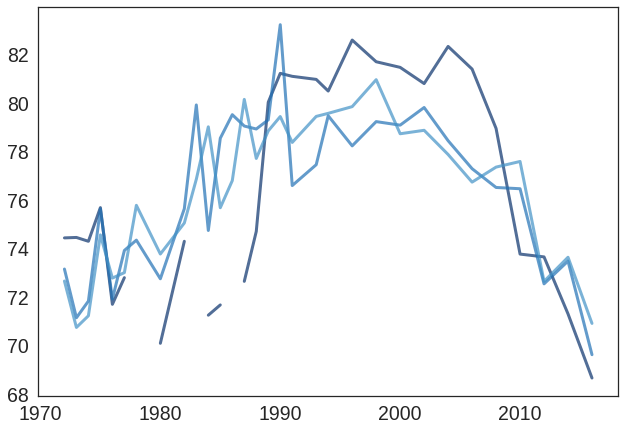

In [255]:
actual = pd.Series([])
counter = pd.Series([])
for name, group in grouped_year4:
    counter[name] = predict_favor(group, model)
    actual[name] = group.favor.mean() * 100

thinkplot.plot(actual.index, actual)
thinkplot.plot(retro.index, retro)
thinkplot.plot(counter.index, counter)

### Run counterfactuals

## Favor gunlaw

In [ ]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

In [ ]:
def plot_series(series, **options):
    """Plots Series objects.
    
    series: Series
    """
    thinkplot.plot(series.dropna(), **options)

In [ ]:
def plot_gunlaw(grouped):
    """.
    
    grouped:
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [ ]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor')
favor

In [ ]:
plot_series(favor, color=BLUE, label='favor')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
crime = make_series(grouped_year, 'crime')
crime

In [ ]:
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
plot_series(favor, color=BLUE, label='favor')
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(title='Support for gun control and concern about crime',
                 xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
grouped_age = sample.groupby(['age_group'])

In [ ]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [ ]:
grouped_cohort = sample.groupby(['cohort5'])

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri.year

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree, color=ORANGE)

In [ ]:
plot_gunlaw(grouped_cohort)
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [ ]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factorscen
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [ ]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
model = make_logit_model(sample, 'favor', factors)

In [ ]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [ ]:
age = sample.loc[sample.year==2016, 'age']

In [ ]:
predict_logit_model(age, model, 1976, factors)

In [ ]:
predict_logit_model(age, model, 2016, factors)

In [ ]:
predict_logit_model(age, model, 2026, factors)

In [ ]:
predict_logit_model(age, model, 2036, factors)

In [ ]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [ ]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [ ]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [ ]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [ ]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [ ]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [ ]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
    factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
               'sixties', 'fifties', 'forties', 'thirties', 'twenties']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Favor gun permits

In [ ]:
iters = 31

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

save_options = dict(fmt='png', dpi=50)
thinkplot.SaveFormat('favor_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age', **save_options)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])

# dropping the last data point because its a different question
old = heri[heri.year<2016]
thinkplot.plot(old.yearm18, old.agree, color=ORANGE, label='CIRP')

thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age_cirp', **save_options)

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('favor_year_pred', **save_options)

## Breakdown by political view

In [ ]:
gss.polviews.value_counts()

In [ ]:
liberal = gss[gss.liberal]
liberal.shape

In [ ]:
conservative = gss[gss.conservative]
conservative.shape

In [ ]:
moderate = gss[gss.moderate]
moderate.shape

In [ ]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

In [ ]:
groupvar = 'year'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

## Breakdown by race

In [ ]:
gss.race.value_counts()

In [ ]:
white = gss[gss.race == 1]
white.shape

In [ ]:
black = gss[gss.race == 2]
black.shape

In [ ]:
nonwhite = gss[gss.race.isin([2,3])]
nonwhite.shape

In [ ]:
white.favor.mean(), black.favor.mean(), nonwhite.favor.mean()

In [ ]:
liberal.favor.mean(), moderate.favor.mean(), conservative.favor.mean()

In [ ]:
white.liberal.mean(), black.liberal.mean(), nonwhite.liberal.mean()

In [ ]:
white.threatened.mean(), black.threatened.mean(), nonwhite.threatened.mean()

In [ ]:
gss.groupby('threatened').favor.mean()

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by race', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_race_year', **save_options)

In [ ]:
young = gss[gss.age<30]
young_white = young[young.race == 1]
young_nonwhite = young[young.race.isin([2,3])]

groupvar = 'year4'

In [ ]:
dfs_white = run_data(young_white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(young_nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[40, 100], loc='lower left')

#thinkplot.SaveFormat('permit_cohort_race', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_race', **save_options)

## Gun in home

In [ ]:
groupvar = 'year'
varnames = ['gunhome']

In [ ]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', **save_options)

In [ ]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', **save_options)

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri

In [ ]:
old = heri[heri.year<2016]
new = heri[heri.year>=2016]

In [ ]:
thinkplot.plot(old.year, old.agree, color=ORANGE, label='"Do more to control sale of handguns"')
thinkplot.plot(new.year, new.agree, 's', color=RED, label='"Should have stricter gun control laws"')

thinkplot.config(title='Favor gun control, CIRP Freshman Survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1987, 2018], ylim=[60, 90], loc='lower left')

thinkplot.SaveFormat('control_year_cirp', **save_options)

## Age effect

In [ ]:
sample.head()

In [ ]:
grouped = sample.groupby('cohort10')
for name, group in grouped:
    print(name, len(group))

In [ ]:
cohort = grouped.get_group(1950.0)

In [ ]:
def plot_favor_by_age(cohort, **options):
    age_groups = cohort.groupby('age3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
names = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0]
labels = ['40s', '50s', '60s', '70s', '80s', '90s']
colors = [RED, ORANGE, YELLOW, GREEN, BLUE, PURPLE]

for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 80], ylim=[40, 95], loc='lower right')

thinkplot.SaveFormat('favor_birth_age', **save_options)

In [ ]:
def plot_favor_by_year(cohort, **options):
    age_groups = cohort.groupby('year4')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_year(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2019], ylim=[40, 95], loc='lower left')

thinkplot.SaveFormat('favor_birth_year', **save_options)

In [ ]:
formula = 'favor ~ a + a2 + c + c2 + C(cohort10)'
formula = 'favor ~ a + a2 + c + c2'
formula = 'favor ~ a + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'

model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
def predict_favor_by_age(model, birth_year):
    age = np.linspace(20, 65)
    cohort = np.ones_like(age) * birth_year
    new = pd.DataFrame(dict(age=age, cohort=cohort))
    center_factors(new)
    predicted = model_predict(model, new)
    return predicted

In [ ]:
def plot_predicted_by_age(predicted, **options):
    thinkplot.plot(predicted.age, predicted.pred, **options)

In [ ]:
name = 1950.0
predicted = predict_favor_by_age(model, name)
plot_predicted_by_age(predicted, color=RED, linewidth=20, alpha=0.1)

cohort = grouped.get_group(name)
plot_favor_by_age(cohort, label='50s', color=RED)

In [ ]:
for i, name in enumerate(names):
    predicted = predict_favor_by_age(model, name)
    plot_predicted_by_age(predicted, color=colors[i], linewidth=5, alpha=0.2)
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, by age', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 70], ylim=[40, 95], loc='lower right')

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', **save_options)